In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [ ]:
here = Path.cwd()
root = next(p for p in [here, *here.parents] if (p / "data" / "processed").exists())

df_v3 = pd.read_csv(root / "data" / "processed" / "merged" / "state1_clean.csv", header=0)
df_v3.head() 

,is_ios,source_file,eventType,eventSampleSpeed,eventDurationSeconds,eventMilesDriven,eventSensorDetectionMthd,eventGPSSignalStrength,eventStartSpeed,eventEndSpeed,memsMedianHorizontalNorm,gyro_angular_change_per_second,gyroAngleChange,mems_radius
0,0,android_turns.csv,4.0,10.394929,7.244125,0.016991,2.0,1.480796,17.323687,6.789408,1.046972,9.521707,69.319600,22.941639
1,0,android_turns.csv,4.0,9.401910,7.497719,0.016103,2.0,1.693853,6.197542,10.101060,1.153392,11.245602,84.723694,20.737572
2,0,android_turns.csv,5.0,11.290954,4.244563,0.008359,2.0,21.173470,11.229438,9.081976,5.708309,24.616348,105.462135,18.996666
3,0,android_turns.csv,5.0,12.743101,3.173500,0.007654,1.0,15.306123,10.714942,13.421639,3.099853,17.929585,57.610783,23.959110
4,0,android_turns.csv,5.0,8.986107,5.990321,0.013587,0.0,19.387754,2.729067,20.937756,1.197121,2.787075,16.806042,91.713660


In [3]:
df_v3.drop(columns=['source_file'], inplace=True)

sub_df_right = df_v3[df_v3['eventType'] == 5]
sub_df_right = sub_df_right.drop(columns=['is_ios', 'eventType', 'eventSampleSpeed', 'eventSensorDetectionMthd', 'eventGPSSignalStrength'])

In [5]:
sub_df_right.columns.tolist()

['eventDurationSeconds',
 'eventMilesDriven',
 'eventStartSpeed',
 'eventEndSpeed',
 'memsMedianHorizontalNorm',
 'gyro_angular_change_per_second',
 'gyroAngleChange',
 'mems_radius']

In [6]:
scaler =StandardScaler()

X_features = sub_df_right
features = scaler.fit_transform(X_features)
scaled_df = pd.DataFrame(features,columns=X_features.columns)

# Print the scaled data
X = scaled_df.values
scaled_df.head(2)


,eventDurationSeconds,eventMilesDriven,eventStartSpeed,eventEndSpeed,memsMedianHorizontalNorm,gyro_angular_change_per_second,gyroAngleChange,mems_radius
0,-0.255254,-0.583691,-0.476287,-0.929513,3.650594,2.117809,1.087867,-0.487198
1,-0.586721,-0.612994,-0.529993,-0.406077,1.062070,0.936588,-0.108381,-0.336605


In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
results = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(features)

    sil = silhouette_score(features, labels)
    ch = calinski_harabasz_score(features, labels)

    results.append((k, sil, ch))

for r in results:
    print(f"k={r[0]} | Silhouette={r[1]:.3f} | CH Score={r[2]:.0f}")

k=2 | Silhouette=0.331 | CH Score=8208
k=3 | Silhouette=0.231 | CH Score=7665
k=4 | Silhouette=0.235 | CH Score=7227
k=5 | Silhouette=0.209 | CH Score=6386
k=6 | Silhouette=0.193 | CH Score=6333
k=7 | Silhouette=0.196 | CH Score=6086
k=8 | Silhouette=0.199 | CH Score=5819
k=9 | Silhouette=0.192 | CH Score=5570


In [12]:
kmeans=KMeans(n_clusters=3)
kmeans.fit(X)
sub_df_right['cluster'] = kmeans.fit_predict(X)

In [13]:
pca=PCA(n_components=2)

reduced_X=pd.DataFrame(data=pca.fit_transform(X),columns=['PCA1','PCA2'])

#Reduced Features
reduced_X.head()

,PCA1,PCA2
0,-1.610527,2.026714
1,-1.368099,0.422220
2,0.140054,-2.146991
3,-0.968097,0.917867
4,-1.486620,-0.229901


In [14]:
centers=pca.transform(kmeans.cluster_centers_)

# reduced centers
centers

array([[ 3.15036357, -0.06955518],
       [-0.67708607,  0.86644542],
       [-0.34893469, -1.34100637]])

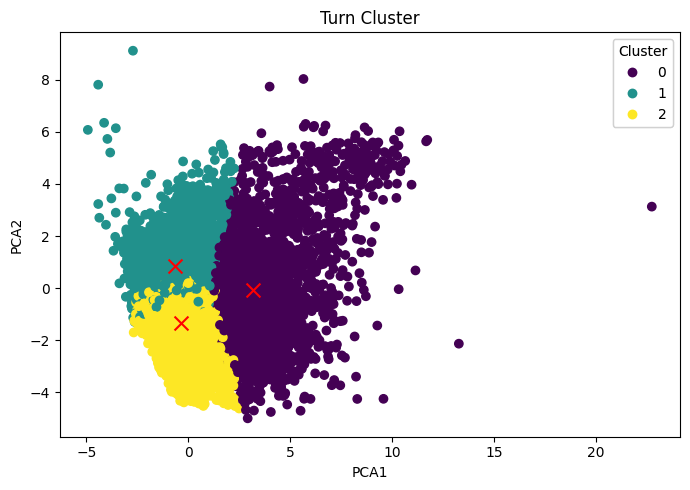

In [18]:
plt.figure(figsize=(7,5))
scatter = plt.scatter(
    reduced_X['PCA1'], reduced_X['PCA2'],
    c=kmeans.labels_, cmap='viridis'
)
plt.scatter(centers[:,0], centers[:,1], marker='x', s=100, c='red')

# Add legend showing which color corresponds to which cluster
legend = plt.legend(
    *scatter.legend_elements(),
    title="Cluster",
    loc="upper right"
)
plt.gca().add_artist(legend)

plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("Turn Cluster")
plt.tight_layout()
plt.show()

In [17]:
sub_df_right.groupby('cluster').mean(numeric_only=True).T

cluster,0,1,2
eventDurationSeconds,9.288081,4.903772,3.425823
eventMilesDriven,0.062559,0.015709,0.014858
eventStartSpeed,29.625802,12.525174,14.713559
eventEndSpeed,28.858944,13.620671,16.348579
memsMedianHorizontalNorm,1.881747,2.241431,1.761193
gyro_angular_change_per_second,9.306040,16.546179,7.927297
gyroAngleChange,87.294588,76.925178,26.793309
mems_radius,58.504424,17.972569,51.482765
